### Installing dependencies

In [1]:
try:
    import optuna
    import torchmetrics
    import torchvision
    import sklearn
except ImportError:
    !pip install optuna torchmetrics torchvision scikit-learn
    import optuna
    import torchmetrics

/home/cdsw/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model development ResNet34

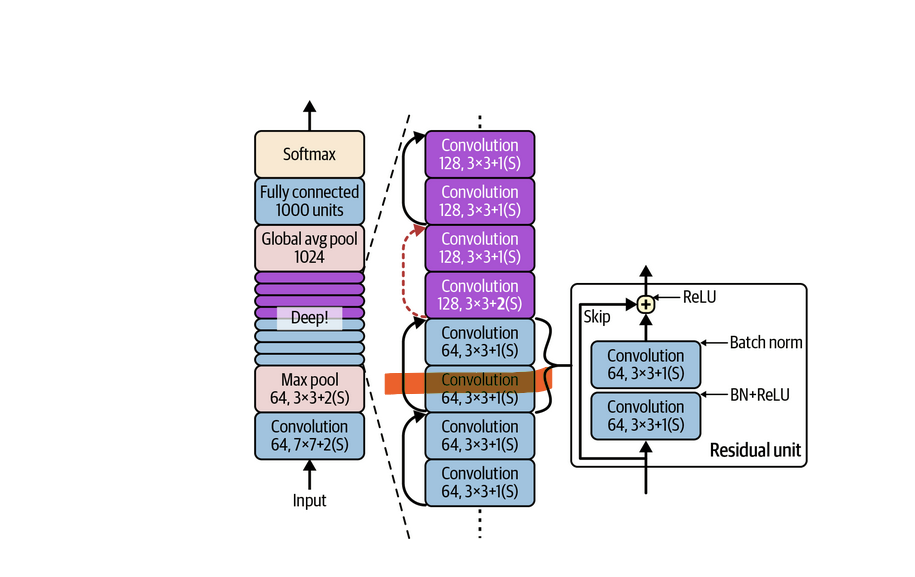

In [2]:
import torch
from functools import partial
from torch import nn

#Each residual unit is composed of two convolutional layers (and no pooling layer!),
#with batch normalization (BN) and ReLU activation,
#using 3 × 3 kernels and preserving spatial dimensions (stride 1, "same" padding).

#conv 3x3 kernel ,padding=same,stride=1
class ResidualUnit(nn.Module):
  def __init__(self,in_channels,out_channels,stride=1):
    super().__init__()

    defaultconv2d=partial(nn.Conv2d,kernel_size=3,stride=1,padding=1,bias=False)

    self.mainlayer=nn.Sequential(
        defaultconv2d(in_channels=in_channels,out_channels=out_channels,stride=stride),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(),
        defaultconv2d(in_channels=out_channels,out_channels=out_channels),
        nn.BatchNorm2d(num_features=out_channels)

    )

    #ensuring correct shape
    if stride>1:

      self.skip_connection= nn.Sequential(
          nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=1,stride=stride,padding=0),
          nn.BatchNorm2d(num_features=out_channels)
      )
    else:
      self.skip_connection=nn.Identity()

    self.relu=nn.ReLU()

  def forward(self,X):

    X=self.skip_connection(X) + self.mainlayer(X)
    return self.relu(X)

#takes in 224 × 224 images
class ResNet34(nn.Module):
  def __init__(self):
    super().__init__()
    #intial layers, append the deep portion here
    self.layers=[nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=3),
                 nn.BatchNorm2d(num_features=64),
                 nn.ReLU(),
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1)]

    #creating residual units
    prev_filters=64
    for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
            stride = 1 if filters == prev_filters else 2
            self.layers.append(ResidualUnit(prev_filters,filters,stride=stride))
            prev_filters=filters
    #final layers (lazylinear auto detect in_features)
    final_layers=[nn.AdaptiveAvgPool2d(1),nn.Flatten(),nn.LazyLinear(10)]
    self.layers+=final_layers

    self.final=nn.Sequential(*self.layers)

  def forward(self,X):
    return self.final(X)

model=ResNet34()
#model(x)

#for name,child in model.named_children():
#  print(child)

### Data Prep with preprocessing

In [3]:
import torchvision
import torch
from torchvision.transforms import v2
from torchvision.transforms import Compose
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
import numpy as np


transform = Compose([
    v2.RandomRotation(degrees=30),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])




train_original = torchvision.datasets.CIFAR10('train',train=True,download=True,transform=transform)
test = torchvision.datasets.CIFAR10('test',train=True,download=True,transform=transform )

targets = np.array(train_original.targets)

sss = StratifiedShuffleSplit(n_splits=1,test_size=0.3)

train_idx, val_idx = next(
    sss.split(np.zeros(len(targets)), targets)
)

train = Subset(train_original, train_idx)
valid   = Subset(train_original, val_idx)


train_loader=DataLoader(train,128)
valid_loader=DataLoader(valid,128)
test_loader=DataLoader(test,128)

x,y=next(iter(train_loader))
print(x.shape)
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

device='cuda' if torch.cuda.is_available() else 'cpu'

torch.Size([128, 3, 32, 32])
274
118
391


In [4]:
device

'cuda'

### Training

Model 1: Regular Cross Validation (no hyperparameter tuning) Includes learning rate scheduler,warm up scheduler and early call back function. 

In [4]:
from torchmetrics import Accuracy
import optuna
from optuna import trial
model= ResNet34()

model.to(device)
optim= torch.optim.NAdam(model.parameters())
loss_fn= torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
  optim, mode="min", patience=2, factor=0.1)
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
    optim, start_factor=0.1, end_factor=1.0, total_iters=3)
metric= Accuracy(task="multiclass", num_classes=10).to(device)


def evalulation(model,dataloader):
    metric.reset()
    model.eval()
    loss_per_epoch=[]
    with torch.no_grad():
        for X,y in dataloader:
            X,y=X.to(device),y.to(device)

            pred=model(X)
            loss=loss_fn(pred,y)
            metric.update(pred,y)
            loss_per_epoch.append(loss.item())
    return sum(loss_per_epoch)/len(loss_per_epoch) , metric.compute()

def train_step(model,train_dataloader,valid_dataloader,loss_fn,optim):
  metric.reset()
  model.train()
  train_loss_per_epoch=[]
  for X,y in train_dataloader:
    X,y=X.to(device),y.to(device)
    pred= model(X)
    loss=loss_fn(pred,y)
    loss.backward()
    metric.update(pred,y)
    train_loss_per_epoch.append(loss.item())
    optim.step()
    optim.zero_grad()

  train_loss=sum(train_loss_per_epoch)/len(train_loss_per_epoch)
  train_acc= metric.compute()
  valid_loss,valid_acc = evalulation(model,valid_dataloader)
  return train_loss,train_acc,valid_loss,valid_acc

def epoch_training(model,max_patience,train_loader,valid_loader,loss_fn,optim,checkpoint_path=None,scheduler=None,warmup_scheduler=None,epochs=100,trial=trial):
  patience=0
  best_loss = float("inf")
  best_acc=0
  plot_valid_loss=[]
  plot_train_loss=[]
  for i in range(1,epochs+1):
    warmup_scheduler.step()
    train_loss,train_acc,valid_loss,valid_acc=train_step(model,train_loader,valid_loader,loss_fn,optim)
    if i%2==0:
      print(f' EPOCH: {i} || train loss: {train_loss} | train acc: {train_acc} | valid loss: {valid_loss} | valid acc: {valid_acc}')
    if valid_loss< best_loss:
      best_loss=valid_loss
      best_acc=valid_acc
      patience=0
      torch.save(model.state_dict(),checkpoint_path)
      print('best saved..')
    else:
      patience+=1
      if patience>=max_patience:
        print('early stopping!')
        print('Last Info:')
        print(f'train loss: {train_loss} | train acc: {train_acc} | valid loss: {valid_loss} | valid acc: {valid_acc}')
        break
    plot_train_loss.append(train_loss)
    plot_valid_loss.append(valid_loss)
   # trial.report(valid_acc, i)
   # if trial.should_prune():
    #    raise optuna.TrialPruned()
    if i>=3:
      scheduler.step(valid_loss)
  return plot_valid_loss,plot_train_loss,valid_acc

plot_valid_loss,plot_train_loss,valid_acc=epoch_training(model,max_patience=5,checkpoint_path='best_model.pt',scheduler=scheduler,warmup_scheduler=warmup_scheduler,epochs=25,valid_loader=valid_loader,train_loader=train_loader,loss_fn=loss_fn,optim=optim)

best saved..
 EPOCH: 2 || train loss: 1.2739735624215898 | train acc: 0.5407999753952026 | valid loss: 1.8414289688659926 | valid acc: 0.43700000643730164
best saved..
best saved..
 EPOCH: 4 || train loss: 0.9555978620574422 | train acc: 0.6612571477890015 | valid loss: 1.2561328870765234 | valid acc: 0.5856000185012817
best saved..
best saved..
 EPOCH: 6 || train loss: 0.7863249807027135 | train acc: 0.7233142852783203 | valid loss: 0.9335765171859224 | valid acc: 0.6755333542823792
 EPOCH: 8 || train loss: 0.6746318032489206 | train acc: 0.7637714147567749 | valid loss: 0.7800120792146457 | valid acc: 0.7318666577339172
best saved..
 EPOCH: 10 || train loss: 0.5944013004972987 | train acc: 0.7909714579582214 | valid loss: 0.8116236056311655 | valid acc: 0.7300666570663452
best saved..
 EPOCH: 12 || train loss: 0.5355125792922765 | train acc: 0.8121142983436584 | valid loss: 0.7165411811763958 | valid acc: 0.7593333125114441
best saved..
 EPOCH: 14 || train loss: 0.47119857011920346 |

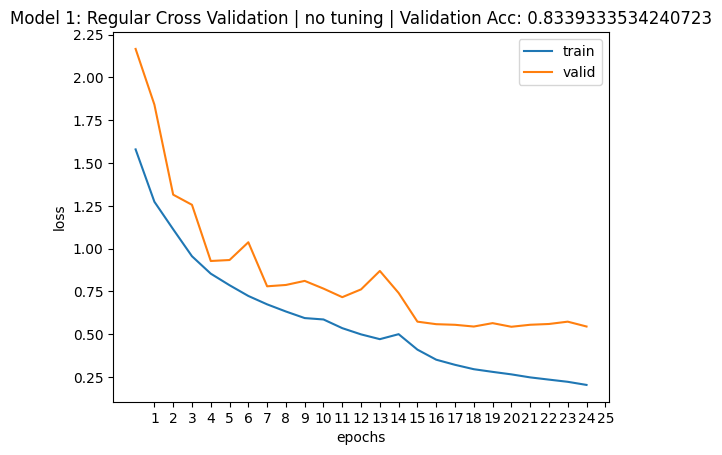

In [5]:
import matplotlib.pyplot as plt
epochs=range(1,len(plot_valid_loss)+1)

plt.plot(plot_train_loss,label='train')
plt.plot(plot_valid_loss,label='valid')

plt.xticks(epochs)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title(f'Model 1: Regular Cross Validation | no tuning | Validation Acc: {valid_acc}')
plt.show()

In [6]:
_,metric_res=evalulation(model,test_loader)
print(f'Model Accuracy on test set: {metric_res}')

Model Accuracy on test set: 0.9035400152206421


model2: with fine tuning LR


In [8]:
import optuna
from optuna import trial
from torchmetrics import Accuracy
def evalulation(model,dataloader,metric,loss_fn):
    metric.reset()
    model.eval()
    loss_per_epoch=[]
    with torch.no_grad():
        for X,y in dataloader:
            X,y=X.to(device),y.to(device)

            pred=model(X)
            loss=loss_fn(pred,y)
            metric.update(pred,y)
            loss_per_epoch.append(loss.item())
    return sum(loss_per_epoch)/len(loss_per_epoch) , metric.compute()

def train_step(model,train_dataloader,valid_dataloader,loss_fn,optim,metric):
  metric.reset()
  model.train()
  train_loss_per_epoch=[]
  for X,y in train_dataloader:
    X,y=X.to(device),y.to(device)
    pred= model(X)
    loss=loss_fn(pred,y)
    loss.backward()
    metric.update(pred,y)
    train_loss_per_epoch.append(loss.item())
    optim.step()
    optim.zero_grad()

  train_loss=sum(train_loss_per_epoch)/len(train_loss_per_epoch)
  train_acc= metric.compute()
  valid_loss,valid_acc = evalulation(model,valid_dataloader,metric,loss_fn)
  return train_loss,train_acc,valid_loss,valid_acc


def epoch_training(model,max_patience,train_loader,valid_loader,loss_fn,
                   optim,metric,checkpoint_path=None,scheduler=None,warmup_scheduler=None,epochs=100,trial=None):
  patience=0
  best_loss = float("inf")
  best_acc=0
  plot_valid_loss=[]
  plot_train_loss=[]
  for i in range(1,epochs+1):
    warmup_scheduler.step()
    train_loss,train_acc,valid_loss,valid_acc=train_step(model,train_loader,valid_loader,loss_fn,optim,metric)
    if i%2==0:
      print(f' EPOCH: {i} || train loss: {train_loss} | train acc: {train_acc} | valid loss: {valid_loss} | valid acc: {valid_acc}')
    if valid_loss< best_loss:
      best_loss=valid_loss
      best_acc=valid_acc
      patience=0
      torch.save(model.state_dict(),checkpoint_path)
      print('best saved..')
    else:
      patience+=1
      if patience>=max_patience:
        print('early stopping!')
        print('Last Info:')
        print(f'train loss: {train_loss} | train acc: {train_acc} | valid loss: {valid_loss} | valid acc: {valid_acc}')
        break
    plot_train_loss.append(train_loss)
    plot_valid_loss.append(valid_loss)
    if trial is not None:
      trial.report(valid_acc, i)
      if trial.should_prune():
          raise optuna.TrialPruned()
    if i>=3:
      scheduler.step(valid_loss)
  return plot_valid_loss,plot_train_loss,valid_acc,best_loss


def objective(trial):
  lr = trial.suggest_float("lr", 1e-3, 5e-2, log=True)



  model= ResNet34()
  model.to(device)
  optim= torch.optim.NAdam(model.parameters(),lr=lr)
  loss_fn= torch.nn.CrossEntropyLoss()
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim, mode="min", patience=2, factor=0.1)
  warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
      optim, start_factor=0.1, end_factor=1.0, total_iters=3)
    
  metric = Accuracy(task="multiclass", num_classes=10).to(device)

  plot_valid_loss,plot_train_loss,valid_acc,best_loss=epoch_training(model,
                                                                     max_patience=5,
                                                                     checkpoint_path='best_model2.pt',scheduler=scheduler,warmup_scheduler=warmup_scheduler,
                                                                     epochs=25,valid_loader=valid_loader,train_loader=train_loader,loss_fn=loss_fn,optim=optim, 
                                                                     trial=trial,metric=metric)
  return best_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)


[I 2025-12-27 12:28:32,549] A new study created in memory with name: no-name-9f163372-0a38-42f6-a10b-19ddb32ce70e


best saved..
 EPOCH: 2 || train loss: 1.502775835294793 | train acc: 0.44762855768203735 | valid loss: 1.5410684367357674 | valid acc: 0.448199987411499
best saved..
best saved..
 EPOCH: 4 || train loss: 1.160544633212751 | train acc: 0.5821714401245117 | valid loss: 1.5532572643231537 | valid acc: 0.4715999960899353
best saved..
 EPOCH: 6 || train loss: 0.9614007151039847 | train acc: 0.6557999849319458 | valid loss: 1.461708767939422 | valid acc: 0.5332000255584717
best saved..
 EPOCH: 8 || train loss: 0.8195784892478999 | train acc: 0.7132571339607239 | valid loss: 1.2681096246687031 | valid acc: 0.5630000233650208
 EPOCH: 10 || train loss: 0.702306771474163 | train acc: 0.7540571689605713 | valid loss: 1.5242231882224648 | valid acc: 0.5333999991416931
best saved..
 EPOCH: 12 || train loss: 0.4998111709626052 | train acc: 0.8271428346633911 | valid loss: 0.6412035017195394 | valid acc: 0.7843999862670898
best saved..
 EPOCH: 14 || train loss: 0.44474005905816155 | train acc: 0.8463

[I 2025-12-27 12:47:39,303] Trial 0 finished with value: 0.6030149277994188 and parameters: {'lr': 0.009784943048214948}. Best is trial 0 with value: 0.6030149277994188.


 EPOCH: 24 || train loss: 0.28557181124487063 | train acc: 0.9003714323043823 | valid loss: 0.6081932530564776 | valid acc: 0.8083999752998352
early stopping!
Last Info:
train loss: 0.28557181124487063 | train acc: 0.9003714323043823 | valid loss: 0.6081932530564776 | valid acc: 0.8083999752998352
best saved..
 EPOCH: 2 || train loss: 1.4197089206563296 | train acc: 0.48254284262657166 | valid loss: 2.026100008164422 | valid acc: 0.3617333471775055
best saved..
 EPOCH: 4 || train loss: 1.0611543087628637 | train acc: 0.624914288520813 | valid loss: 1.8355639627424336 | valid acc: 0.41179999709129333
 EPOCH: 6 || train loss: 0.8718190876236798 | train acc: 0.6949714422225952 | valid loss: 1.0851317911835041 | valid acc: 0.6225333213806152
best saved..
 EPOCH: 8 || train loss: 0.7408476780800923 | train acc: 0.7408857345581055 | valid loss: 1.2262449032169278 | valid acc: 0.6050666570663452
 EPOCH: 10 || train loss: 0.5363050594817113 | train acc: 0.8129714131355286 | valid loss: 0.65148

[I 2025-12-27 13:07:34,837] Trial 1 finished with value: 0.5913219722145695 and parameters: {'lr': 0.004471090673051467}. Best is trial 1 with value: 0.5913219722145695.


best saved..
 EPOCH: 2 || train loss: 1.4937951938949363 | train acc: 0.4510571360588074 | valid loss: 16.87001770633762 | valid acc: 0.17766666412353516
best saved..
 EPOCH: 4 || train loss: 1.1783620119094849 | train acc: 0.5736285448074341 | valid loss: 1.3696407968715085 | valid acc: 0.5436000227928162
best saved..
 EPOCH: 6 || train loss: 0.9976245264937408 | train acc: 0.644685685634613 | valid loss: 1.9643950149164362 | valid acc: 0.5195333361625671
best saved..
 EPOCH: 8 || train loss: 0.8591881899067956 | train acc: 0.6958857178688049 | valid loss: 1.2581116981425529 | valid acc: 0.5762666463851929
best saved..
best saved..
 EPOCH: 10 || train loss: 0.7352681266565393 | train acc: 0.7433428764343262 | valid loss: 1.246437524334859 | valid acc: 0.6172666549682617
best saved..
 EPOCH: 12 || train loss: 0.6526178607757944 | train acc: 0.7731714248657227 | valid loss: 1.2705949054936232 | valid acc: 0.6176666617393494
 EPOCH: 14 || train loss: 0.5817933916828059 | train acc: 0.796

[I 2025-12-27 13:27:33,121] Trial 2 finished with value: 0.5962242683616735 and parameters: {'lr': 0.014748455064862765}. Best is trial 1 with value: 0.5913219722145695.


best saved..
 EPOCH: 2 || train loss: 1.2442819156350882 | train acc: 0.5491714477539062 | valid loss: 1.3223141744985418 | valid acc: 0.5345333218574524
best saved..
 EPOCH: 4 || train loss: 0.940931522933236 | train acc: 0.6664857268333435 | valid loss: 1.1342406176914603 | valid acc: 0.5965999960899353
best saved..
 EPOCH: 6 || train loss: 0.7667484918650049 | train acc: 0.7340285778045654 | valid loss: 1.2059873893099315 | valid acc: 0.6055333614349365
 EPOCH: 8 || train loss: 0.5521428352289827 | train acc: 0.8084571361541748 | valid loss: 0.633497179059659 | valid acc: 0.7796666622161865
best saved..
best saved..
 EPOCH: 10 || train loss: 0.4819682196979105 | train acc: 0.8322571516036987 | valid loss: 0.6218451892925521 | valid acc: 0.7881333231925964
best saved..
 EPOCH: 12 || train loss: 0.4475405108537117 | train acc: 0.8456000089645386 | valid loss: 0.6259728152368028 | valid acc: 0.7876666784286499
best saved..
 EPOCH: 14 || train loss: 0.4131007156994221 | train acc: 0.858

[I 2025-12-27 13:47:25,706] Trial 3 finished with value: 0.5770345264572209 and parameters: {'lr': 0.001408605313234526}. Best is trial 3 with value: 0.5770345264572209.


best saved..
 EPOCH: 2 || train loss: 1.3027441599508272 | train acc: 0.5281714200973511 | valid loss: 1.4839326446339236 | valid acc: 0.4809333384037018
best saved..
best saved..
 EPOCH: 4 || train loss: 0.9709865022314726 | train acc: 0.6565999984741211 | valid loss: 1.2020023000442375 | valid acc: 0.5788000226020813
best saved..
best saved..
 EPOCH: 6 || train loss: 0.7986169463961664 | train acc: 0.7202000021934509 | valid loss: 1.1576699089195768 | valid acc: 0.6114000082015991
best saved..
 EPOCH: 8 || train loss: 0.6857367862750144 | train acc: 0.7617999911308289 | valid loss: 1.0740572476791124 | valid acc: 0.6532666683197021
 EPOCH: 10 || train loss: 0.5955111015669621 | train acc: 0.7924571633338928 | valid loss: 0.8715655874397795 | valid acc: 0.7162666916847229
best saved..
best saved..
 EPOCH: 12 || train loss: 0.5294200590927235 | train acc: 0.817714273929596 | valid loss: 1.039977677292743 | valid acc: 0.6846666932106018
 EPOCH: 14 || train loss: 0.47582069789841225 | tr

[I 2025-12-27 14:07:20,720] Trial 4 finished with value: 0.6335914167812315 and parameters: {'lr': 0.002195193341014271}. Best is trial 3 with value: 0.5770345264572209.


best saved..
 EPOCH: 2 || train loss: 1.5068972819913042 | train acc: 0.4455428719520569 | valid loss: 1.8069975083157168 | valid acc: 0.4004666805267334
best saved..
 EPOCH: 4 || train loss: 1.1872513046229842 | train acc: 0.5723999738693237 | valid loss: 2.201217573578075 | valid acc: 0.3750666677951813
best saved..
 EPOCH: 6 || train loss: 0.9995930123068121 | train acc: 0.6448285579681396 | valid loss: 1.6162287754527593 | valid acc: 0.48046666383743286
best saved..
best saved..
 EPOCH: 8 || train loss: 0.8535769662282763 | train acc: 0.7007142901420593 | valid loss: 1.2917705804614696 | valid acc: 0.5887333154678345
 EPOCH: 10 || train loss: 0.746310739839164 | train acc: 0.7401999831199646 | valid loss: 1.8565877554780346 | valid acc: 0.4771333336830139
best saved..
 EPOCH: 12 || train loss: 0.5210148797635614 | train acc: 0.8171142935752869 | valid loss: 0.6799844687773009 | valid acc: 0.7663333415985107
best saved..
 EPOCH: 14 || train loss: 0.4721443618301058 | train acc: 0.83

[I 2025-12-27 14:27:15,051] Trial 5 finished with value: 0.6314142066038261 and parameters: {'lr': 0.025096773255806264}. Best is trial 3 with value: 0.5770345264572209.


early stopping!
Last Info:
train loss: 0.265948998884563 | train acc: 0.9071999788284302 | valid loss: 0.6454427651429581 | valid acc: 0.7998666763305664


[I 2025-12-27 14:28:02,980] Trial 6 pruned. 


best saved..


[I 2025-12-27 14:28:50,880] Trial 7 pruned. 


best saved..


[I 2025-12-27 14:29:38,849] Trial 8 pruned. 


best saved..
best saved..
 EPOCH: 2 || train loss: 1.5304307115339015 | train acc: 0.4352285861968994 | valid loss: 1.9315803758168624 | valid acc: 0.35713332891464233
best saved..
best saved..
 EPOCH: 4 || train loss: 1.2036822629671027 | train acc: 0.5693714022636414 | valid loss: 1.4693265385546928 | valid acc: 0.46860000491142273
best saved..
 EPOCH: 6 || train loss: 1.010051361618251 | train acc: 0.6452857255935669 | valid loss: 1.728894810555345 | valid acc: 0.4341999888420105
best saved..
 EPOCH: 8 || train loss: 0.89107341096349 | train acc: 0.6857143044471741 | valid loss: 1.359037999884557 | valid acc: 0.5386666655540466
best saved..
best saved..
 EPOCH: 10 || train loss: 0.7930132485654232 | train acc: 0.722342848777771 | valid loss: 1.2964618261587821 | valid acc: 0.5951333045959473
 EPOCH: 12 || train loss: 0.7143897446837738 | train acc: 0.7537428736686707 | valid loss: 1.1244162821163566 | valid acc: 0.6350666880607605
best saved..
 EPOCH: 14 || train loss: 0.48559130162

[I 2025-12-27 14:49:28,164] Trial 9 finished with value: 0.6287795845734871 and parameters: {'lr': 0.03934639519532834}. Best is trial 3 with value: 0.5770345264572209.


best saved..


In [12]:
best_lr=study.best_params.get('lr')

In [11]:
print(f'Optimised Learning Rate: {study.best_params})

{'lr': 0.001408605313234526}


In [15]:
# rerunning training with optimised parameter

model= ResNet34()
model.to(device)
optim= torch.optim.NAdam(model.parameters(),lr=best_lr)
loss_fn= torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode="min", patience=2, factor=0.1)
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optim, start_factor=0.1, end_factor=1.0, total_iters=3)
    
metric = Accuracy(task="multiclass", num_classes=10).to(device)

plot_valid_loss,plot_train_loss,valid_acc,best_loss=epoch_training(model,
                                                                     max_patience=5,
                                                                     checkpoint_path='best_model2.pt',scheduler=scheduler,warmup_scheduler=warmup_scheduler,
                                                                     epochs=25,valid_loader=valid_loader,train_loader=train_loader,loss_fn=loss_fn,optim=optim, 
                                                                     metric=metric)


best saved..
 EPOCH: 2 || train loss: 1.2496718720798075 | train acc: 0.5490000247955322 | valid loss: 1.2856921280844738 | valid acc: 0.5548666715621948
best saved..
 EPOCH: 4 || train loss: 0.9339491533536981 | train acc: 0.673628568649292 | valid loss: 1.3368723831944547 | valid acc: 0.5429333448410034
best saved..
 EPOCH: 6 || train loss: 0.7682977105579237 | train acc: 0.7323428392410278 | valid loss: 1.0241065343557778 | valid acc: 0.662933349609375
best saved..
best saved..
 EPOCH: 8 || train loss: 0.662183353935715 | train acc: 0.769428551197052 | valid loss: 1.0608233289193298 | valid acc: 0.6519333124160767
best saved..
 EPOCH: 10 || train loss: 0.5833268014401415 | train acc: 0.7975142598152161 | valid loss: 0.9048056077148955 | valid acc: 0.6955999732017517
 EPOCH: 12 || train loss: 0.5203685046982591 | train acc: 0.8194000124931335 | valid loss: 0.793422907085742 | valid acc: 0.7321333289146423
best saved..
 EPOCH: 14 || train loss: 0.4690239936330893 | train acc: 0.837171

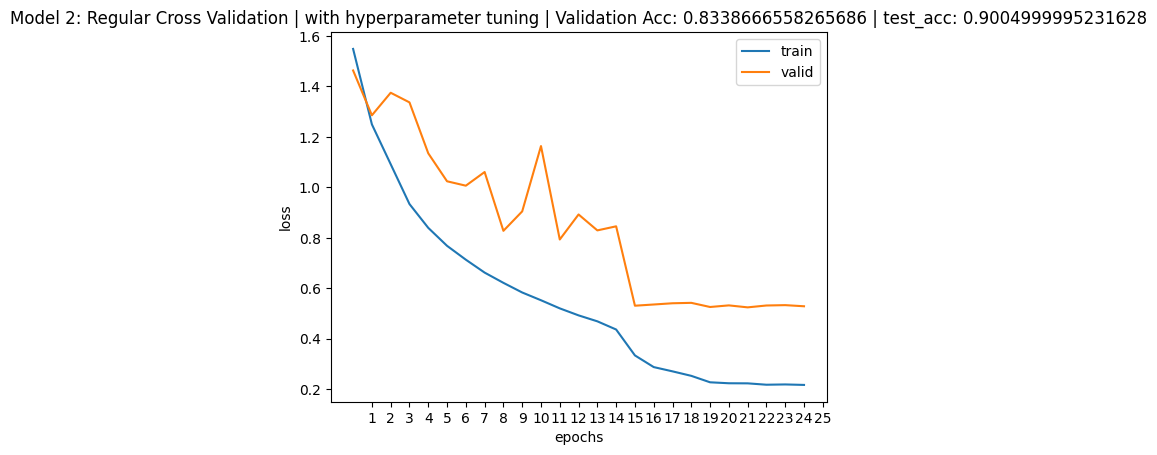

In [19]:
import matplotlib.pyplot as plt


_,test_acc=evalulation(model,test_loader,metric,loss_fn)

epochs=range(1,len(plot_valid_loss)+1)

plt.plot(plot_train_loss,label='train')
plt.plot(plot_valid_loss,label='valid')

plt.xticks(epochs)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title(f'Model 2: Regular Cross Validation | with hyperparameter tuning | Validation Acc: {valid_acc} | test_acc: {test_acc}')
plt.show()

In [18]:
_,final_acc=evalulation(model,test_loader,metric,loss_fn)

(0.306421794511778, tensor(0.8993, device='cuda:0'))